In [4]:
## **Machine Learning for Physics and Astronomy**

BSc program in Physics and Astronomy (Honours track), University van Amsterdam and Vrije Universiteit Amsterdam.

**Academic year 2021-2022**. 

Course instructors:

* Dr. Juan Rojo ([j.rojo@vu.nl](mailto:j.rojo@vu.nl))

* Dr. Tommaso Giani ([tgiani@nikhef.nl](mailto:tgiani@nikhef.nl))

* Mr. Ryan van Mastrigt ([ryanvmastrigt@gmail.com](mailto:ryanvmastrigt@gmail.com))
    
Lecture notes, tutorial notebooks, and other learning materials of the course can be found in its [GitHub repository](https://github.com/LHCfitNikhef/ML4PA)

## Tutorial 3 (extra): Non-linear regression with neural networks for Electron Energy Loss Spectroscopy

---


SyntaxError: invalid syntax (<ipython-input-4-ef401bdef048>, line 3)

# **Tutorial - Zero-Loss Peak Subtraction using PyTorch**

Author: Jaco ter Hoeve

email: j.j.ter.hoeve at vu dot nl

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LHCfitNikhef/ML4PA/blob/master/tutorials/tutorial-TEM/EELS_tutorial.ipynb)

## Using Google Colab

An easy way of running the code in this notebook is by using Google Colab. It uses the CPUs/GPUs at Google and comes with a lot of pre-installed packages. Just click the "Open in Colab" button above to get started.

## Motivation

In this tutorial, we will be developing a model-independent way of removing the zero-loss peak (ZLP) from an EEL spectrum. The ZLP often overwhelms the contributions associated to inelastics scatterings off the specimen. Therefore, relevant signals of low-loss phenomena (such as excitions and phonons) risk becoming drowned in the ZLP tail. An accurate removal of the ZLP contribution is thus crucial in order to chart and identify these features.

Spectral images in Electron Energy Loss Spectroscopy (EELS) are two-dimensional sets of spectra. To simplify our lives, we will be analysing only a subset of the whole spectral image with similar thickness. This way we make sure that the underlying ZLPs at different pixels acrross our subset are more or less similar.

Let us start by getting a feel of what our data looks like by loading it. We study the material WS2, tungsten disulfide.

## Loading the data

First of all, we must install and import a couple of modules.

In [1]:
#load external packages

#uncomment the three lines below to download the spectral images and two python modules that we need
!pip install ncempy
#!wget https://github.com/LHCfitNikhef/ML4PA/raw/master/tutorials/tutorial-TEM/area03-eels-SI-aligned.dm4
#!wget https://raw.githubusercontent.com/LHCfitNikhef/ML4PA/master/tutorials/tutorial-TEM/imageClass.py
#!wget https://raw.githubusercontent.com/LHCfitNikhef/ML4PA/master/tutorials/tutorial-TEM/trainZLP.py

from ncempy.io import dm
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os
import math
import seaborn as sns
from sklearn.model_selection import train_test_split

import imageClass as EELSImage
import trainZLP as ZLPnn

Once we have downloaded our spectral image, we can use it to create a python object `im` that contains all the relevant info that we need throughout this tutorial.

In [2]:
path_to_dm4 = 'area03-eels-SI-aligned.dm4'
im = EELSImage.Spectral_image.load_data(path_to_dm4)

## Plotting our data

Visualsing our data sounds like an obvious next step, which can be easily done in just a few lines of code. Try changing the location of `loc_x` and `loc_y` to see how the spectrum varies accross the image.

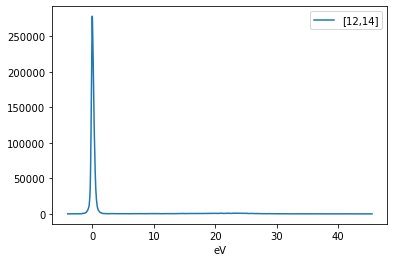

In [3]:
full_width, full_height = im.image_shape[1], im.image_shape[0]
loc_x, loc_y = int(0.1 * full_width), int(0.15 * full_height)
spectrum = im.plot_spectrum(loc_y, loc_x)

Next, we want to select only a subset of the entire image as our training data. It is important that the selected `window` covers pixels of more or less the same thickness. Running the cell below produces a heatmap of the integrated intensity accross the image, as well as a close-up of your selection. 

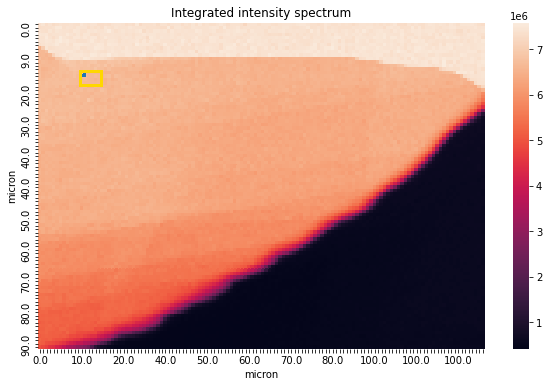

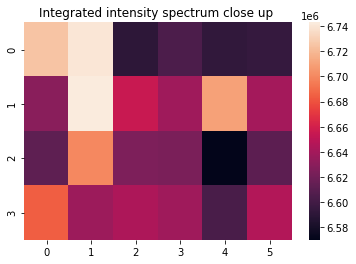

In [4]:
xmin, width = int(0.1 * full_width), int(0.05 * full_width)
ymin, height = int(0.15 * full_height), int(0.05 * full_height)

window = np.array([[xmin, width], [ymin, height]])
im.show_image(selection = window, pixel_highlight = [loc_x, loc_y])

## Selecting our training data

We cannot use the entire spectrum to train the ZLP, since low-loss features start to kick in relatively soon. Therefore, we construct three regions to further split up our training set. For energy losses $\Delta E \leq \Delta E_I$ (region 1), the ZLP dominates over the inelastic scatterings and so we can safely use this as our training data. For $\Delta E \geq \Delta E_{II}$ we use pseudo-data that drive the ZLP to zero (as it should). The EELS measurements in region 2, defined by $\Delta E_{I} \leq \Delta E \leq \Delta E_{II}$ are exclused from the training dataset.

To find "good" values of $\Delta E_I$ and $\Delta E_{II}$, we first need to smooth our data.

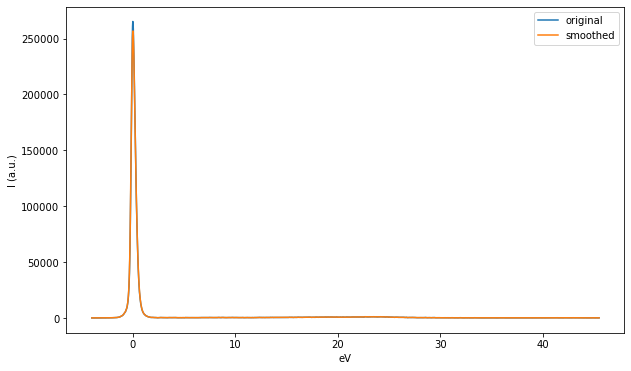

In [5]:
data_zoomed_concat = np.reshape(im.data_zoomed, (-1, im.l))
data_smooth = ZLPnn.smooth(data_zoomed_concat, window_len = 10)

# show the effect of smoothing on the second to last pixel
plt.figure(figsize=(10,6))
plt.plot(im.deltaE, im.data_zoomed[-1, -2, :], label = 'original')
plt.plot(im.deltaE, data_smooth[-2,:], label = 'smoothed')
plt.xlabel("eV")
plt.ylabel("I (a.u.)")
plt.legend()
plt.show()

In the ultra-low loss region, characterised by $\Delta E \simeq$ few eV, the contributions of the ZLP and those from inealstic interactions become comparable. As a crude measure of where this region starts, we decide to look slightly to the left of the first local minimum in the EELS spectrum.

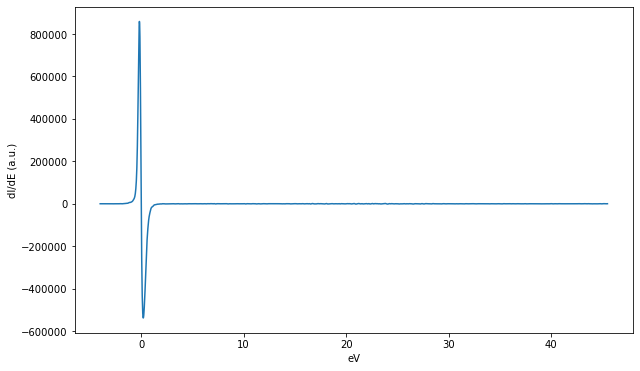

In [6]:
def der_spect(image, spectrum):
    dx = image.ddeltaE
    der_spectrum = (spectrum[:,1:]-spectrum[:,:-1])/dx
    return der_spectrum

der = der_spect(im, data_smooth)
der_smooth = ZLPnn.smooth(der, window_len = 10)

# plot the slope of the EELS spectrum
plt.figure(figsize=(10,6))
plt.plot(im.deltaE[:-1], der_smooth[-1,:])
plt.xlabel("eV")
plt.ylabel("dI/dE (a.u.)")
plt.show()

Now we are ready to find $\Delta E_{I}$ and $\Delta E_{II}$

In [7]:
data_avg = np.average(data_smooth, axis=0)
der_avg = np.average(der, axis=0)

dE1 = ZLPnn.find_dE1(im, der_avg, data_avg, fct=0.7) # subtract 30% of the first local minimum to find dE1

times_dE1 = 3 # multiplicative factor that determines the location of dE2
min_dE2 = im.deltaE.max() - im.ddeltaE * im.l * 0.05 
dE2 = np.minimum(dE1 * times_dE1, min_dE2) 

In [8]:
# selection indices 
select1 = np.argwhere(np.diff(np.sign(im.deltaE - dE1))).flatten()[0]
select2 = np.argwhere(np.diff(np.sign(im.deltaE - dE2))).flatten()[0]

## Rescaling our training data

To avoid our neurons from getting saturated and giving very small gradients, we will standardize our input features to zero mean and unit variance. This will significantly speed up the training of our neural network. 

In the following, we will only include 20 values of $\Delta E$ past $\Delta E_{II}$. This will enforce the condition that the ZLP vanishes at large $\Delta E$ without dominating the training algorithm.

In [9]:
# Due to noise we have have some negative intensities. Set these to epsilon by hand.
epsilon = 1e-3
data_zoomed_concat[data_zoomed_concat < 0] = epsilon

<function matplotlib.pyplot.show(close=None, block=None)>

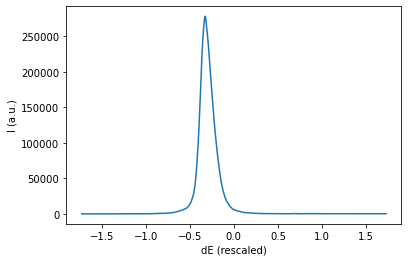

In [10]:
def rescale(data, mean, std):
    return (data - mean) / std

ndat_reg3 = 20
mean = np.mean(im.deltaE[:select2 + ndat_reg3])
std = np.std(im.deltaE[:select2 + ndat_reg3])
deltaE_scaled = rescale(im.deltaE[:select2 + ndat_reg3], mean, std)

plt.plot(deltaE_scaled[:select2 + ndat_reg3], data_zoomed_concat[0][:select2 + ndat_reg3])
plt.xlabel("dE (rescaled)")
plt.ylabel("I (a.u.)")
plt.show

The cuts $\Delta E_I$ and $\Delta E_{II}$ still need to be applied though. Let us do this now and plot the result (we now plot the log of the intensity instead).

In [11]:
# input features
data_x = np.ones(select1 + ndat_reg3)
data_x[:select1] = deltaE_scaled[:select1]
data_x[select1:] = deltaE_scaled[select2:select2 + ndat_reg3]

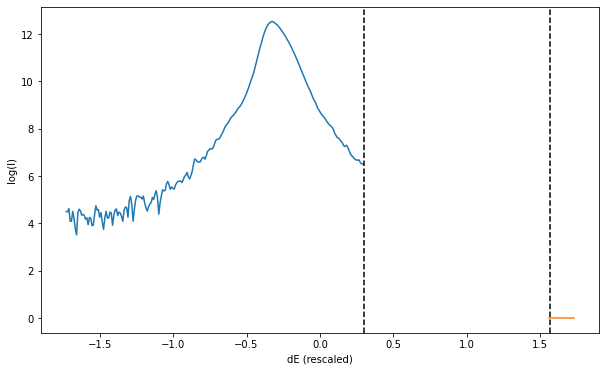

In [12]:
# error on measured data
ci_low = np.nanpercentile(np.log(data_zoomed_concat), 16, axis=0)
ci_high = np.nanpercentile(np.log(data_zoomed_concat), 84, axis=0)
sigma = np.absolute(ci_high - ci_low)

data_sigma = sigma[:select1]
data_sigma = np.append(data_sigma, 0.8 * np.ones(ndat_reg3))

# select a representative spectrum (here the first one) and plot 
data_y = np.log(data_zoomed_concat[0][:select1])
data_y = np.append(data_y, np.zeros(ndat_reg3))

fig, ax = plt.subplots(figsize = (10,6))
plt.plot(data_x[:select1], data_y[:select1])
plt.plot(data_x[select1:], data_y[select1:select1+ndat_reg3])
ax.axvline(rescale(dE2, mean, std), 0, 1, linestyle = 'dashed', color = 'k')
ax.axvline(rescale(dE1, mean, std), 0, 1, linestyle = 'dashed', color = 'k')
plt.xlabel("dE (rescaled)")
plt.ylabel("log(I)")
plt.show()

## Training and validation set

We should be careful not to overfit our training data. That is, fitting noise rather than the true underlying physical law. A common way of avoiding this is to split our data into two sets: a training set on which we train our model, and a validation set on which we evaluate our model performances.

As an example, study the following code snippet that splits our spectrum randomly into two sets, the training and the validation set.

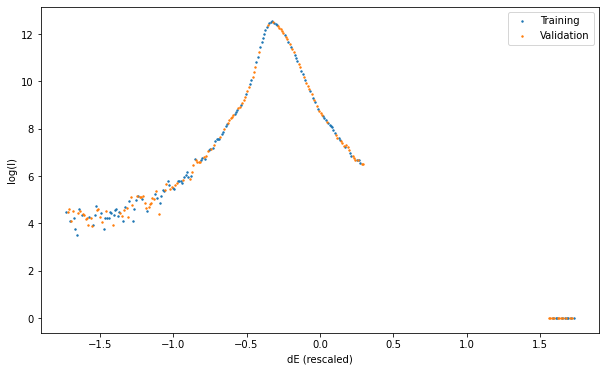

In [13]:
train_x, val_x, train_y, val_y, train_sigma, val_sigma = train_test_split(data_x, data_y, data_sigma, test_size=0.5)

# plot the training set
plt.figure(figsize=(10,6))
plt.scatter(train_x[np.argsort(train_x)], train_y[np.argsort(train_x)], s=2, label = 'Training')

# plot the validation set
plt.scatter(val_x[np.argsort(val_x)], val_y[np.argsort(val_x)], s=2, label = 'Validation')

plt.xlabel("dE (rescaled)")
plt.ylabel("log(I)")
plt.legend()
plt.show()


## Constructing the Neural Network

After all this data preprocessing work, it is time to start constructing the neural network and to train it!

Replica 0, Epoch 1, Training loss 82689.05042935556, Validation loss 62246.38203488577
Replica 0, Epoch 500, Training loss 34045.356734339824, Validation loss 25344.859238047145
Replica 0, Epoch 1000, Training loss 16165.876751623693, Validation loss 11889.019102468772
Replica 0, Epoch 1500, Training loss 6916.292481811801, Validation loss 5014.5483824979865
Replica 0, Epoch 2000, Training loss 2791.4105077641907, Validation loss 2023.9177728791954
Replica 0, Epoch 2500, Training loss 1345.8282762316567, Validation loss 1034.3832619394013
Replica 0, Epoch 3000, Training loss 987.6526902560477, Validation loss 827.5380385733027
Replica 0, Epoch 3500, Training loss 932.2443240014202, Validation loss 815.0052274884364
Replica 0, Epoch 4000, Training loss 927.6057803437513, Validation loss 820.9935905893487
Replica 0, Epoch 4500, Training loss 927.4270461302885, Validation loss 822.8673992743893
Replica 0, Epoch 5000, Training loss 927.4219388626375, Validation loss 823.11307697365
Replica

Replica 4, Epoch 2500, Training loss 846.8143222956224, Validation loss 886.757751595697
Replica 4, Epoch 3000, Training loss 846.7471128036035, Validation loss 887.2081540710061
Replica 4, Epoch 3500, Training loss 846.6913333262058, Validation loss 887.1438744178965
Replica 4, Epoch 4000, Training loss 846.3031112476169, Validation loss 886.4269271852119
Replica 4, Epoch 4500, Training loss 835.1397282535415, Validation loss 865.9155510986816
Replica 4, Epoch 5000, Training loss 834.8059623768812, Validation loss 865.4600345214882
Replica 4, Epoch 5500, Training loss 539.2736927706198, Validation loss 484.80814959444155
Replica 4, Epoch 6000, Training loss 528.9929297874191, Validation loss 477.12138476270326
Replica 4, Epoch 6500, Training loss 526.6356831607378, Validation loss 475.2710596906775
Replica 4, Epoch 7000, Training loss 525.5962483252116, Validation loss 474.4188027099996
Replica 4, Epoch 7500, Training loss 524.8800087588043, Validation loss 473.835186540643
Replica 4,

Replica 9, Epoch 500, Training loss 6084.383563784772, Validation loss 6382.7096413007675
Replica 9, Epoch 1000, Training loss 1658.558278977552, Validation loss 1747.5885255912833
Replica 9, Epoch 1500, Training loss 977.0559522228936, Validation loss 931.8661833416894
Replica 9, Epoch 2000, Training loss 909.3678413889147, Validation loss 811.4597960287047
Replica 9, Epoch 2500, Training loss 905.9473424461261, Validation loss 794.7316470416521
Replica 9, Epoch 3000, Training loss 905.8310412251013, Validation loss 792.5801945684584
Replica 9, Epoch 3500, Training loss 905.7399452823619, Validation loss 792.3234462819471
Replica 9, Epoch 4000, Training loss 905.4985843287345, Validation loss 792.1120559105543
Replica 9, Epoch 4500, Training loss 901.9864664491232, Validation loss 789.6092083736801
Replica 9, Epoch 5000, Training loss 542.9971018442556, Validation loss 462.46096967926064
Replica 9, Epoch 5500, Training loss 537.7942995579272, Validation loss 457.75103856454643
Replica

Replica 13, Epoch 500, Training loss 8581.517880249983, Validation loss 8429.164632732376
Replica 13, Epoch 1000, Training loss 2344.4972623718972, Validation loss 2326.190056929977
Replica 13, Epoch 1500, Training loss 1074.7972128605995, Validation loss 1054.7513005366343
Replica 13, Epoch 2000, Training loss 884.2128910415937, Validation loss 846.7191482633494
Replica 13, Epoch 2500, Training loss 868.7171493748167, Validation loss 825.959245347969
Replica 13, Epoch 3000, Training loss 868.0784520636815, Validation loss 824.0678679356016
Replica 13, Epoch 3500, Training loss 868.0344970800932, Validation loss 823.8316356644082
Replica 13, Epoch 4000, Training loss 867.9949720637096, Validation loss 823.7510836001759
Replica 13, Epoch 4500, Training loss 867.9457213352734, Validation loss 823.6759137373415
Replica 13, Epoch 5000, Training loss 867.8629550899328, Validation loss 823.5807662367758
Replica 13, Epoch 5500, Training loss 867.3771767420941, Validation loss 823.215960271613

Replica 16, Epoch 17500, Training loss 2.1118854933758597, Validation loss 0.3742818225208396
Replica 16, Epoch 18000, Training loss 1.967108281278469, Validation loss 0.37210996189681694
Replica 16, Epoch 18500, Training loss 1.8619737825915392, Validation loss 0.37662988234535866
Replica 16, Epoch 19000, Training loss 1.7784082308071647, Validation loss 0.3656817263056403
Replica 16, Epoch 19500, Training loss 1.7294801678936185, Validation loss 0.3532468516415633
Replica 16, Epoch 20000, Training loss 1.6923647346101443, Validation loss 0.34155171301837833
Replica 16, Epoch 20500, Training loss 1.6625930011462755, Validation loss 0.33201505061954906
Replica 16, Epoch 21000, Training loss 1.637107377636448, Validation loss 0.32354229244440347
Replica 16, Epoch 21500, Training loss 1.613606338869322, Validation loss 0.3167971396771563
Replica 16, Epoch 22000, Training loss 1.5909710469675797, Validation loss 0.3141316288051462
Replica 16, Epoch 22500, Training loss 1.5665798276387748,

Replica 17, Epoch 21500, Training loss 523.3291203560299, Validation loss 452.48120787084474
Replica 17, Epoch 22000, Training loss 523.3279084058715, Validation loss 452.4664375482117
Replica 17, Epoch 22500, Training loss 523.3275230789022, Validation loss 452.5181678244857
Replica 17, Epoch 23000, Training loss 523.3262243216578, Validation loss 452.43526027567515
Replica 17, Epoch 23500, Training loss 523.3255967210478, Validation loss 452.4286749688978
Replica 17, Epoch 24000, Training loss 523.3249881512327, Validation loss 452.4089610716117
Replica 17, Epoch 24500, Training loss 523.324460642938, Validation loss 452.4057759842894
Replica 17, Epoch 25000, Training loss 523.3239322303713, Validation loss 452.3935861460953
Replica 17, Epoch 25500, Training loss 523.3233373208108, Validation loss 452.3762664879635
Replica 17, Epoch 26000, Training loss 523.3237330083346, Validation loss 452.3423951376705
Replica 17, Epoch 26500, Training loss 523.3222460317461, Validation loss 452.3

Replica 19, Epoch 11000, Training loss 546.4362762430371, Validation loss 427.64784683976154
Replica 19, Epoch 11500, Training loss 546.37068041411, Validation loss 427.6155368017392
Replica 20, Epoch 1, Training loss 73301.07936443246, Validation loss 51509.781420354266
Replica 20, Epoch 500, Training loss 8784.34881214449, Validation loss 5429.02400562339
Replica 20, Epoch 1000, Training loss 2300.731421479189, Validation loss 1332.2624490513674
Replica 20, Epoch 1500, Training loss 1063.168747153443, Validation loss 789.32852160912
Replica 20, Epoch 2000, Training loss 897.4320411244994, Validation loss 824.3648874668139
Replica 20, Epoch 2500, Training loss 885.087648857541, Validation loss 863.0737583426195
Replica 20, Epoch 3000, Training loss 884.6685734129018, Validation loss 872.2779345997095
Replica 20, Epoch 3500, Training loss 884.6620718716612, Validation loss 873.3798668527365
Replica 20, Epoch 4000, Training loss 884.6602204836274, Validation loss 873.4293686806681
Repli

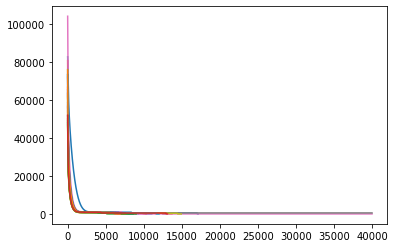

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import datetime

class MLP(nn.Module):

    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, 10)
        self.linear2 = nn.Linear(10, 15)
        self.linear3 = nn.Linear(15, 5)
        self.output = nn.Linear(5, num_outputs)
        self.tanh = nn.Tanh()
        #self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        x = self.tanh(x)
        x = self.linear3(x)
        x = self.tanh(x)
        x = self.output(x)
        return x
    
def loss_fn(output, target, error):
    loss = torch.mean(torch.square((output - target)/error))
    return loss

def weight_reset(m):
    if isinstance(m, nn.Linear):
        m.reset_parameters()
        
def training_loop(n_rep, n_epochs, optimizer, model, loss_fn):
    
    
    for rep in range(n_rep):
        
        model.apply(weight_reset)
        
        path = './models/rep_{}'.format(rep)
        if not os.path.exists(path):
            os.makedirs(path)
        
        # load the log intensity of spectrum rep
        data_y = np.log(data_zoomed_concat[rep][:select1])
        data_y = np.append(data_y, np.zeros(20))
       
        # create training and validation sets
        train_x, test_x, train_y, test_y, train_sigma, test_sigma = train_test_split(data_x, data_y, data_sigma, test_size=0.5)

        # convert numpy array to tensors and reshape
        train_x = torch.tensor(train_x).unsqueeze(-1)
        test_x = torch.tensor(test_x).unsqueeze(-1) 
        
        train_y = torch.tensor(train_y).unsqueeze(-1)
        test_y = torch.tensor(test_y).unsqueeze(-1)
        
        train_sigma = torch.tensor(train_sigma).unsqueeze(-1)
        test_sigma = torch.tensor(test_sigma).unsqueeze(-1)
        
        # define lists that keep track of the loss per epoch
        validation_loss = []
        training_loss = []
        
        loss_val_old = 0
        overfit_counter = 0
        patience = 100
        for epoch in range(1, n_epochs + 1):
                    
            model_output = model(train_x.float())
            
            loss = loss_fn(model_output, train_y, train_sigma)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            loss_train = loss.item()
            training_loss.append(loss_train)
        
            #validation loss
            with torch.no_grad():
                model_output = model(test_x.float())
                val_loss = loss_fn(model_output, test_y, test_sigma)
                loss_val = val_loss.item()
                validation_loss.append(loss_val)
                assert val_loss.requires_grad == False
             
            if loss_val > loss_val_old and epoch > 1:
                overfit_counter += 1
            else:
                overfit_counter = 0
                
            if loss_train < 0.8:
                break


#             if overfit_counter == patience:
#                 torch.save(model.state_dict(), './models/rep_{}/trained_nn.pt'.format(rep))
#                 print("\n Overfitting detected! Training loss {}".format(loss_train))
#                 #best_epoch = epoch - patience
#                 break
                
#            loss_val_old = loss_val
            
            
            if epoch == 1 or epoch % 500 == 0:
                print('Replica {}, Epoch {}, Training loss {}, Validation loss {}'.format(rep, epoch, loss_train, loss_val))
        
        torch.save(model.state_dict(), './models/rep_{}/trained_nn.pt'.format(rep))

        plt.plot(training_loss)

n_rep = im.data_zoomed.shape[0] * im.data_zoomed.shape[1]
n_epochs = 40000
model = MLP(num_inputs=1, num_outputs=1)
optimizer = optim.Adam(model.parameters(), lr=1e-3)                
                
training_loop(
    n_rep = n_rep,
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn
)

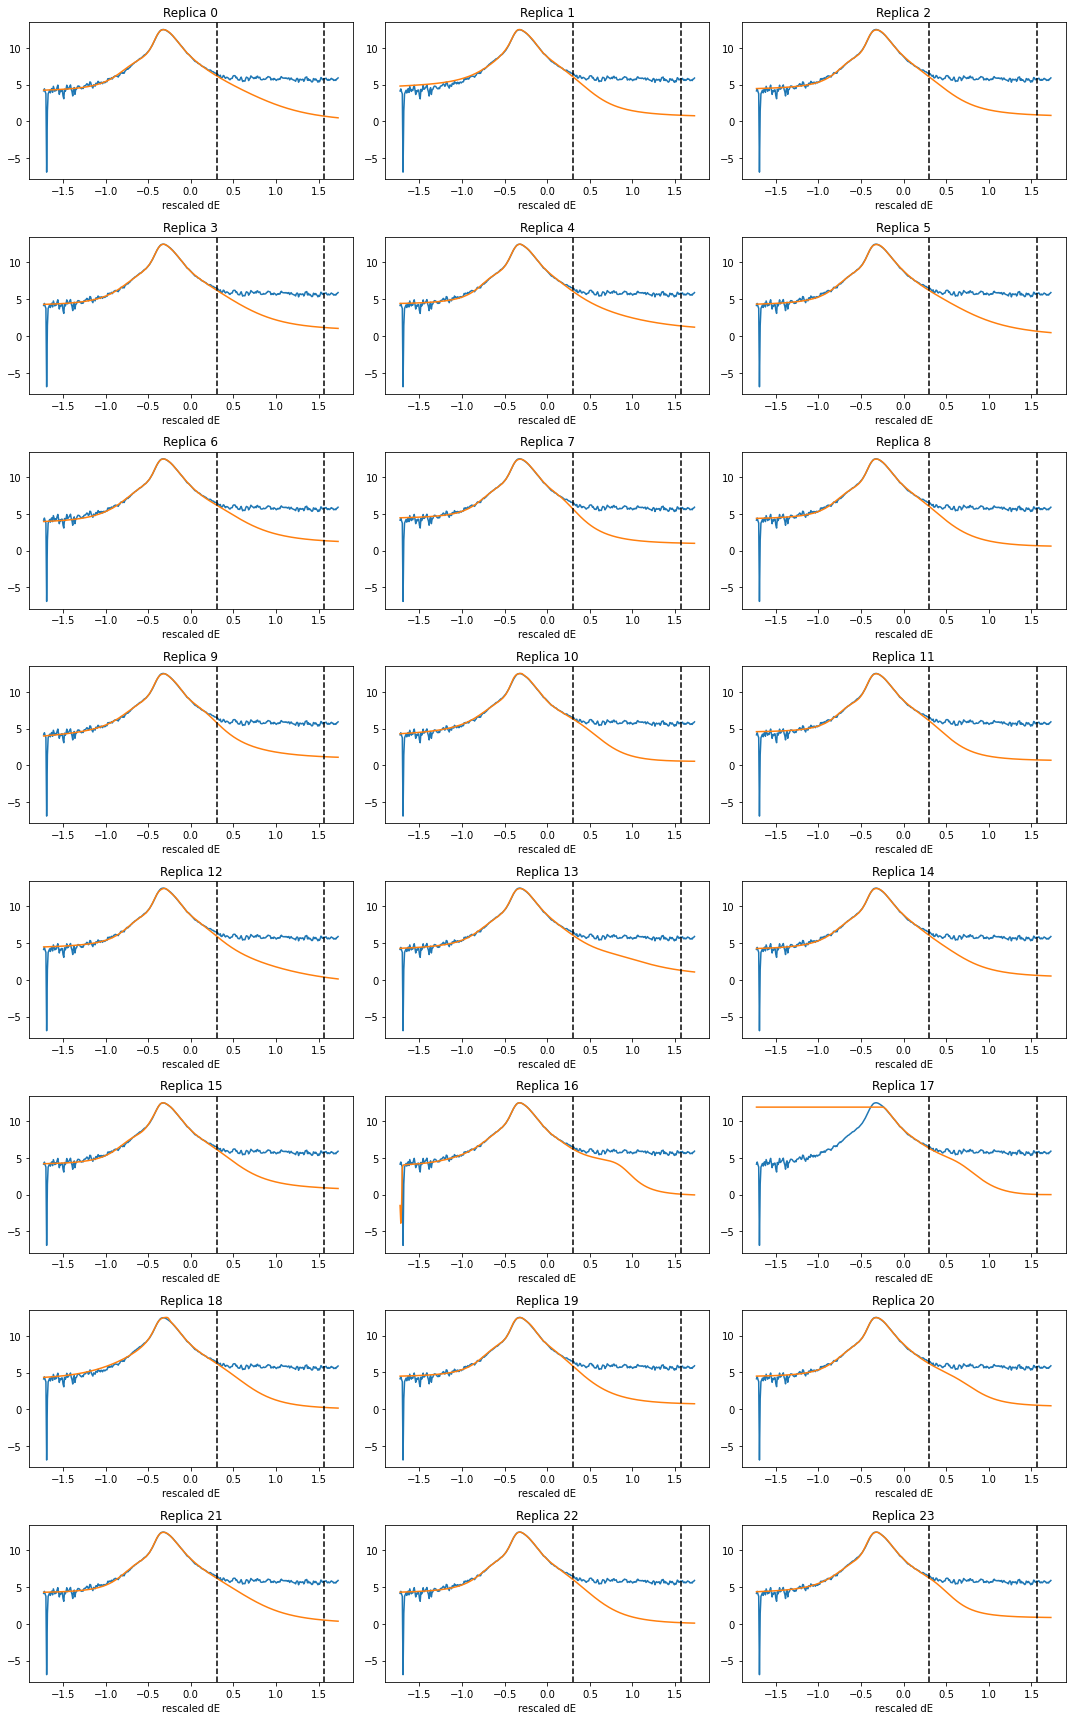

In [15]:
ncols = 3
nrows = math.ceil(n_rep/3)

fig = plt.figure(figsize=(ncols * 5, nrows * 3))
#fig.subplots_adjust(hspace=0.4, wspace=0.4)
deltaE_scaled_tensor = torch.tensor(deltaE_scaled).unsqueeze(-1)
for i in range(0, n_rep):
    ax = fig.add_subplot(nrows, ncols, i+1)
    network_path = './models/rep_{}/trained_nn.pt'.format(i)
    model.load_state_dict(torch.load(network_path))
    model_pred = model.forward(deltaE_scaled_tensor.float())
    model_pred = model_pred.detach().numpy()

    plt.plot(deltaE_scaled, np.log(data_zoomed_concat[2][:select2 + 20]), label = 'original')
    plt.plot(deltaE_scaled, model_pred, label = 'ZLP')
    ax.axvline(rescale(dE2, mean, std), 0, 1, linestyle = 'dashed', color = 'k')
    ax.axvline(rescale(dE1, mean, std), 0, 1, linestyle = 'dashed', color = 'k')
    ax.set_title('Replica {}'.format(i))
    ax.set_xlabel("rescaled dE")
    fig.tight_layout()
plt.show()

## Evaluating the trained models

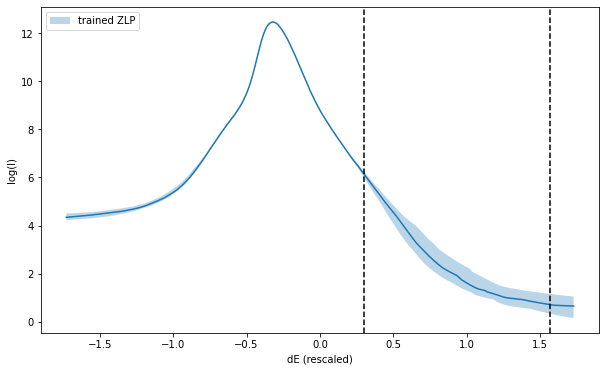

In [16]:
pred = []

for rep in range(n_rep):
    network_path = './models/rep_{}/trained_nn.pt'.format(rep)
    model.load_state_dict(torch.load(network_path))
    
    model_pred = model.forward(deltaE_scaled_tensor.float())
    model_pred = model_pred.detach().numpy()
    pred.append(model_pred[:,0])

pred = np.array(pred)
pred_median = np.median(pred, axis=0)
cl_low = np.nanpercentile(pred, 16, axis=0)
cl_high = np.nanpercentile(pred, 84, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(deltaE_scaled, pred_median)
ax.fill_between(deltaE_scaled, cl_low, cl_high, alpha = 0.3, label = 'trained ZLP')
ax.axvline(rescale(dE2, mean, std), 0, 1, linestyle = 'dashed', color = 'k')
ax.axvline(rescale(dE1, mean, std), 0, 1, linestyle = 'dashed', color = 'k')

plt.xlabel("dE (rescaled)")
plt.ylabel("log(I)")
plt.legend()
plt.show()

## ZLP subtraction

With the ZLP trained, we can now determine the subtracted spectrum.

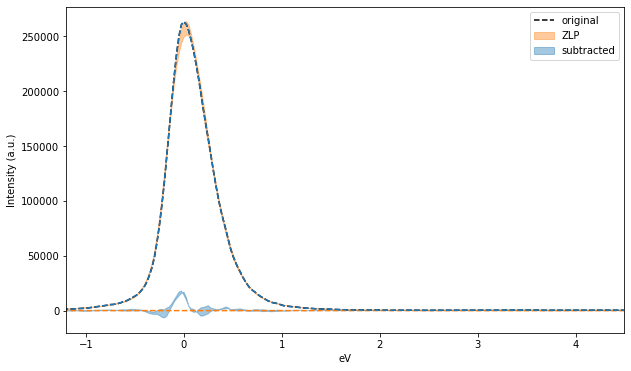

In [17]:
pred_I = np.exp(pred)
pred_I_med = np.median(pred, axis=0)
cl_low = np.nanpercentile(pred_I, 16, axis=0)
cl_high = np.nanpercentile(pred_I, 84, axis=0)


plt.figure(figsize=(10,6))

spectrum = 4
plt.plot(im.deltaE[:select2 + ndat_reg3], data_zoomed_concat[spectrum][:select2 + ndat_reg3], linestyle='dashed', label='original', color='k')
plt.fill_between(im.deltaE[:select2 + ndat_reg3], cl_low[:select2 + ndat_reg3], cl_high[:select2 + 20], alpha = 0.4, label='ZLP', color='C1')
plt.plot(im.deltaE[:select2 + ndat_reg3], pred_I_med[:select2 + ndat_reg3], linestyle = 'dashed', color='C1')
plt.plot(im.deltaE[:select2 + ndat_reg3], data_zoomed_concat[spectrum][:select2 + ndat_reg3] - pred_I_med[:select2 + 20], linestyle='dashed')
plt.fill_between(im.deltaE[:select2 + ndat_reg3], data_zoomed_concat[spectrum][:select2 + ndat_reg3] - cl_low[:select2 + 20], data_zoomed_concat[0][:select2 + 20]- cl_high[:select2 + 20], alpha = 0.4, label='subtracted', color='C0')
plt.xlim(-1.2, 4.5)
plt.xlabel("eV")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.show()



### Exercises: 
1. Explain what would go wrong if instead we also include training data from region 2.

2. Try playing with different optimizers, architectures and learning rates to see how you can optimize the performances

3. As you might have noticed, the training loss stays constant for quite some time before it suddenly drops to $\approx$ 1. Explain what might be causing this and how you could circumvent it.

3. Try to improve the way the stopping point is determined using the validaton set.

4. Try to implement different rescalings. Does the training improve if you rescale the features to lie between 0.1 and 0.9?

